In [52]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')
import requests

from bs4 import BeautifulSoup
import lxml.html as lh

Libraries imported.


In [11]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')

In [12]:
[len(T) for T in tr_elements[0:3]]

[3, 3, 3]

In [13]:

col=[]
i=0

for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))
    
len(tr_elements)
len(col)

1:"Postal Code
"
2:"Borough
"
3:"Neighborhood
"


3

In [14]:

for j in range(1,181):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [15]:
[len(C) for (title,C) in col]

[180, 180, 180]

In [16]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()


,Postal Code\n,Borough\n,Neighborhood\n
0,M1A\n,Not assigned\n,\n
1,M2A\n,Not assigned\n,\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [18]:
df.columns = ['Postal Code','Borough','Neighborhood']
df['Postal Code']=df['Postal Code'].str.replace('\n', '')
df['Borough']=df['Borough'].str.replace('\n', '')
df['Neighborhood']=df['Neighborhood'].str.replace('\n', '')

df['Borough'].replace('Not assigned', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)
df = df.reset_index()
df.drop(['index'], axis=1,inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [19]:
df.shape

(103, 3)

In [20]:
df_coord=pd.read_csv('https://cocl.us/Geospatial_data')
#df_coord=pd.read_csv('c:\\1\\GitHub\\Geospatial_Coordinates.csv')
df_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [21]:
Toronto_coords=pd.merge(df, df_coord, on='Postal Code')
Toronto_coords.head(5)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [22]:
Toronto_coords.shape

(103, 5)

Unique - to creare a unique combination of Borough, Neighborhood and Postal Code.  
Some line have same Borough and Neighborhood and different Postal Code.
Better idea to use unique identifier as coordinates are not exactly the same  
Example below:

M3K	North York	Downsview  
M3L	North York	Downsview


In [316]:
Toronto_coords['Unique'] = df['Borough'] + df['Neighborhood'] + df['Postal Code']
Toronto_coords.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Unique
0,M3A,North York,Parkwoods,43.753259,-79.329656,North YorkParkwoodsM3A
1,M4A,North York,Victoria Village,43.725882,-79.315572,North YorkVictoria VillageM4A
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,"Downtown TorontoRegent Park, HarbourfrontM5A"
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,"North YorkLawrence Manor, Lawrence HeightsM6A"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"Downtown TorontoQueen's Park, Ontario Provinci..."


In [317]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_coords['Latitude'], Toronto_coords['Longitude'], Toronto_coords['Borough'], Toronto_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [318]:
CLIENT_ID = 'QDHUKHP3HCPAUPGDQLCPDSQW5CPUHTX35CQV4ISYL52IGQHL' # your Foursquare ID
CLIENT_SECRET = '3GDQFKX5X0DUFNK4JNB5ETUPTJOGCEMBX4CUQ3LWR2NKU5T5' # your Foursquare Secret
VERSION = '20200510' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QDHUKHP3HCPAUPGDQLCPDSQW5CPUHTX35CQV4ISYL52IGQHL
CLIENT_SECRET:3GDQFKX5X0DUFNK4JNB5ETUPTJOGCEMBX4CUQ3LWR2NKU5T5


In [319]:
neighborhood_latitude = Toronto_coords.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_coords.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto_coords.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [321]:
latitude = neighborhood_latitude
longitude = neighborhood_longitude

radius = 600

LIMIT = 100


url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=QDHUKHP3HCPAUPGDQLCPDSQW5CPUHTX35CQV4ISYL52IGQHL&client_secret=3GDQFKX5X0DUFNK4JNB5ETUPTJOGCEMBX4CUQ3LWR2NKU5T5&ll=43.7532586,-79.3296565&v=20200510&radius=600&limit=100'

In [322]:
#Checking i can access FourthSquare
results = requests.get(url).json()
#results

In [264]:
#Function from the lab to iterate over the lines
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [323]:
#Get information over each Line. Using Unique identifier to avoid stacking same Borough with different Postal Codes
Toronto_venues = getNearbyVenues(names=Toronto_coords['Unique'],
                                   latitudes=Toronto_coords['Latitude'],
                                   longitudes=Toronto_coords['Longitude']
                                  )


North YorkParkwoodsM3A
North YorkVictoria VillageM4A
Downtown TorontoRegent Park, HarbourfrontM5A
North YorkLawrence Manor, Lawrence HeightsM6A
Downtown TorontoQueen's Park, Ontario Provincial GovernmentM7A
EtobicokeIslington AvenueM9A
ScarboroughMalvern, RougeM1B
North YorkDon MillsM3B
East YorkParkview Hill, Woodbine GardensM4B
Downtown TorontoGarden District, RyersonM5B
North YorkGlencairnM6B
EtobicokeWest Deane Park, Princess Gardens, Martin Grove, Islington, CloverdaleM9B
ScarboroughRouge Hill, Port Union, Highland CreekM1C
North YorkDon MillsM3C
East YorkWoodbine HeightsM4C
Downtown TorontoSt. James TownM5C
YorkHumewood-CedarvaleM6C
EtobicokeEringate, Bloordale Gardens, Old Burnhamthorpe, Markland WoodM9C
ScarboroughGuildwood, Morningside, West HillM1E
East TorontoThe BeachesM4E
Downtown TorontoBerczy ParkM5E
YorkCaledonia-FairbanksM6E
ScarboroughWoburnM1G
East YorkLeasideM4G
Downtown TorontoCentral Bay StreetM5G
Downtown TorontoChristieM6G
ScarboroughCedarbraeM1H
North YorkHillc

In [324]:
#Check Venues data
print(Toronto_venues.shape)
Toronto_venues.head()

(2137, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North YorkParkwoodsM3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,North YorkParkwoodsM3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,North YorkParkwoodsM3A,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,North YorkVictoria VillageM4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,North YorkVictoria VillageM4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


Preprocessing Completed, 
Upto identification

In [325]:
#Look for number of venues for each Unique Neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Central TorontoDavisville NorthM4P,7,7,7,7,7,7
Central TorontoDavisvilleM4S,38,38,38,38,38,38
Central TorontoForest Hill North & WestM5P,4,4,4,4,4,4
Central TorontoLawrence ParkM4N,3,3,3,3,3,3
"Central TorontoMoore Park, Summerhill EastM4T",1,1,1,1,1,1
Central TorontoNorth Toronto WestM4R,23,23,23,23,23,23
Central TorontoRoselawnM5N,3,3,3,3,3,3
"Central TorontoSummerhill West, Rathnelly, South Hill, Forest Hill SE, Deer ParkM4V",16,16,16,16,16,16
"Central TorontoThe Annex, North Midtown, YorkvilleM5R",22,22,22,22,22,22


In [326]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 266 uniques categories.


In [328]:
#Two Neighborhoods have no venues for 500m radius
print(Toronto_venues.groupby('Neighborhood').count().shape)
print(Toronto_coords.shape)

(101, 6)
(103, 6)


In [329]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [330]:
Toronto_onehot.shape

(2137, 266)

In [332]:
#Get mean number for each unique neighborhood and prepare data for the modelling
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Central TorontoDavisville NorthM4P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0

In [333]:
Toronto_grouped.shape

(101, 266)

In [334]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central TorontoDavisville NorthM4P----
               venue  freq
0                Gym  0.14
1              Hotel  0.14
2     Breakfast Spot  0.14
3  Food & Drink Shop  0.14
4     Sandwich Place  0.14


----Central TorontoDavisvilleM4S----
                venue  freq
0      Sandwich Place  0.08
1         Pizza Place  0.08
2        Dessert Shop  0.08
3                Café  0.05
4  Italian Restaurant  0.05


----Central TorontoForest Hill North & WestM5P----
              venue  freq
0             Trail  0.25
1              Park  0.25
2  Sushi Restaurant  0.25
3     Jewelry Store  0.25
4       Yoga Studio  0.00


----Central TorontoLawrence ParkM4N----
                venue  freq
0                Park  0.33
1         Swim School  0.33
2            Bus Line  0.33
3         Men's Store  0.00
4  Miscellaneous Shop  0.00


----Central TorontoMoore Park, Summerhill EastM4T----
                      venue  freq
0                Playground   1.0
1               Yoga Studio   0.0
2  Mediterr

In [346]:
#Function to  sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [379]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Unique']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Unique'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.rename(columns={'Neighborhood': 'Unique'})
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()


(101, 11)


,Unique,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central TorontoDavisville NorthM4P,Hotel,Breakfast Spot,Food & Drink Shop,Department Store,Sandwich Place,Gym,Park,Doner Restaurant,Dog Run,Donut Shop
1,Central TorontoDavisvilleM4S,Pizza Place,Dessert Shop,Sandwich Place,Café,Gym,Sushi Restaurant,Italian Restaurant,Coffee Shop,Seafood Restaurant,Diner
2,Central TorontoForest Hill North & WestM5P,Trail,Jewelry Store,Sushi Restaurant,Park,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Curling Ice
3,Central TorontoLawrence ParkM4N,Park,Swim School,Bus Line,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Ethiopian Restaurant,Diner
4,"Central TorontoMoore Park, Summerhill EastM4T",Playground,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center


In [380]:
# set number of clusters. Based on several tests 5 seems to be the most attractive 
kclusters = 5
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

Look at the histogram, neighborhoods seems to be classified mostly by one class - >80%

(array([83.,  0.,  1.,  0.,  0., 13.,  0.,  1.,  0.,  3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

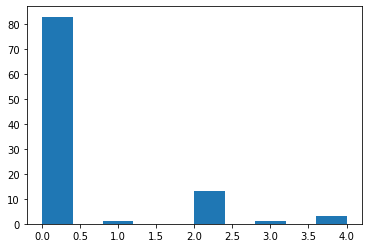

In [381]:
import matplotlib.pyplot as plt
plt.hist(kmeans.labels_)

In [382]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_Merged = Toronto_coords

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_Merged = Toronto_Merged.join(neighborhoods_venues_sorted.set_index('Unique'), on='Unique')

#Label neighborhoods with no venues as a new last class
Toronto_Merged['Cluster Labels']=Toronto_Merged['Cluster Labels'].fillna(kclusters)
Toronto_Merged.head(10) # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,North YorkParkwoodsM3A,2.0,Park,Food & Drink Shop,Bus Stop,College Rec Center,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,M4A,North York,Victoria Village,43.725882,-79.315572,North YorkVictoria VillageM4A,0.0,French Restaurant,Coffee Shop,Hockey Arena,Portuguese Restaurant,Dim Sum Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,"Downtown TorontoRegent Park, HarbourfrontM5A",0.0,Coffee Shop,Park,Pub,Bakery,Café,Theater,Restaurant,Breakfast Spot,Yoga Studio,Event Space
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,"North YorkLawrence Manor, Lawrence HeightsM6A",0.0,Clothing Store,Accessories Store,Event Space,Shoe Store,Vietnamese Restaurant,Miscellaneous Shop,Coffee Shop,Boutique,Arts & Crafts Store,Furniture / Home Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,"Downtown TorontoQueen's Park, Ontario Provinci...",0.0,Coffee Shop,Sushi Restaurant,Burger Joint,Bar,Beer Bar,Italian Restaurant,Juice Bar,Sandwich Place,Distribution Center,Restaurant
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,EtobicokeIslington AvenueM9A,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,"ScarboroughMalvern, RougeM1B",1.0,Fast Food Restaurant,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
7,M3B,North York,Don Mills,43.745906,-79.352188,North YorkDon MillsM3B,0.0,Athletics & Sports,Caribbean Restaurant,Café,Japanese Restaurant,Gym / Fitness Center,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,"East YorkParkview Hill, Woodbine GardensM4B",0.0,Pizza Place,Fast Food Restaurant,Bank,Gym / Fitness Center,Athletics & Sports,Pet Store,Gastropub,Pharmacy,Intersection,Dim Sum Restaurant
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,"Downtown TorontoGarden District, RyersonM5B",0.0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Italian Restaurant,Hotel


In [383]:
# create map
#Toronto_Merged['Cluster Labels']=Toronto_Merged['Cluster Labels'].fillna(8)

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_Merged['Latitude'], Toronto_Merged['Longitude'], Toronto_Merged['Neighborhood'], Toronto_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cl=int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cl-2],
        fill=True,
        fill_color=rainbow[cl-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [384]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 0, Toronto_Merged.columns[[2] + list(range(5, Toronto_Merged.shape[1]))]]

,Neighborhood,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,North YorkVictoria VillageM4A,0.0,French Restaurant,Coffee Shop,Hockey Arena,Portuguese Restaurant,Dim Sum Restaurant,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
2,"Regent Park, Harbourfront","Downtown TorontoRegent Park, HarbourfrontM5A",0.0,Coffee Shop,Park,Pub,Bakery,Café,Theater,Restaurant,Breakfast Spot,Yoga Studio,Event Space
3,"Lawrence Manor, Lawrence Heights","North YorkLawrence Manor, Lawrence HeightsM6A",0.0,Clothing Store,Accessories Store,Event Space,Shoe Store,Vietnamese Restaurant,Miscellaneous Shop,Coffee Shop,Boutique,Arts & Crafts Store,Furniture / Home Store
4,"Queen's Park, Ontario Provincial Government","Downtown TorontoQueen's Park, Ontario Provinci...",0.0,Coffee Shop,Sushi Restaurant,Burger Joint,Bar,Beer Bar,Italian Restaurant,Juice Bar,Sandwich Place,Distribution Center,Restaurant
7,Don Mills,North YorkDon MillsM3B,0.0,Athletics & Sports,Caribbean Restaurant,Café,Japanese Restaurant,Gym / Fitness Center,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
8,"Parkview Hill, Woodbine Gardens","East YorkParkview Hill, Woodbine GardensM4B",0.0,Pizza Place,Fast Food Restaurant,Bank,Gym / Fitness Center,Athletics & Sports,Pet Store,Gastropub,Pharmacy,Intersection,Dim Sum Restaurant
9,"Garden District, Ryerson","Downtown TorontoGarden District, RyersonM5B",0.0,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Restaurant,Middle Eastern Restaurant,Italian Restaurant,Hotel
11,"West Deane Park, Princess Gardens, Martin Grov...","EtobicokeWest Deane Park, Princess Gardens, Ma...",0.0,Golf Course,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
12,"Rouge Hill, Port Union, Highland Creek","ScarboroughRouge Hill, Port Union, Highland Cr...",0.0,Construction & Landscaping,Bar,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store,Dance Studio
13,Don Mills,North YorkDon MillsM3C,0.0,Coffee Shop,Asian Restaurant,Gym,Restaurant,Beer Store,Concert Hall,Clothing Store,Chinese Restaurant,Dim Sum Restaurant,Discount Store


In [385]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 1, Toronto_Merged.columns[[2] + list(range(5, Toronto_Merged.shape[1]))]]

,Neighborhood,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Malvern, Rouge","ScarboroughMalvern, RougeM1B",1.0,Fast Food Restaurant,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [386]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 2, Toronto_Merged.columns[[2] + list(range(5, Toronto_Merged.shape[1]))]]

,Neighborhood,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,North YorkParkwoodsM3A,2.0,Park,Food & Drink Shop,Bus Stop,College Rec Center,Dance Studio,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
10,Glencairn,North YorkGlencairnM6B,2.0,Park,Pub,Metro Station,Japanese Restaurant,Women's Store,Dim Sum Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop
21,Caledonia-Fairbanks,YorkCaledonia-FairbanksM6E,2.0,Park,Pool,Women's Store,Afghan Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
35,East Toronto,East YorkEast TorontoM4J,2.0,Park,Coffee Shop,Convenience Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
40,Downsview,North YorkDownsviewM3K,2.0,Park,Airport,Snack Place,Gift Shop,Gluten-free Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
49,"North Park, Maple Leaf Park, Upwood Park","North YorkNorth Park, Maple Leaf Park, Upwood ...",2.0,Park,Construction & Landscaping,Bakery,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dance Studio
61,Lawrence Park,Central TorontoLawrence ParkM4N,2.0,Park,Swim School,Bus Line,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Ethiopian Restaurant,Diner
64,Weston,YorkWestonM9N,2.0,Park,Curling Ice,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store
66,York Mills West,North YorkYork Mills WestM2P,2.0,Park,Bank,Convenience Store,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Dance Studio
68,Forest Hill North & West,Central TorontoForest Hill North & WestM5P,2.0,Trail,Jewelry Store,Sushi Restaurant,Park,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Curling Ice


In [387]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 3, Toronto_Merged.columns[[2] + list(range(5, Toronto_Merged.shape[1]))]]

,Neighborhood,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Humber Summit,North YorkHumber SummitM9L,3.0,Restaurant,Women's Store,Curling Ice,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


In [388]:
Toronto_Merged.loc[Toronto_Merged['Cluster Labels'] == 4, Toronto_Merged.columns[[2] + list(range(5, Toronto_Merged.shape[1]))]]

,Neighborhood,Unique,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,"Willowdale, Newtonbrook","North YorkWillowdale, NewtonbrookM2M",4.0,Home Service,Women's Store,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center,Curling Ice
53,Downsview,North YorkDownsviewM3M,4.0,Baseball Field,Food Truck,Home Service,Dance Studio,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Women's Store
57,"Humberlea, Emery","North YorkHumberlea, EmeryM9M",4.0,Baseball Field,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


Data seems to be dominated by class with many caffes and restrauns  
Second big class related to Parks  
Smaller class with Baseball Fields